In [ ]:
##Term 2 work
#Saving data, improving functions
#Trying out other sigkernel package

In [1]:
import apache_beam

In [2]:
import os
import weatherbench2
import xarray as xr
import math
from weatherbench2.regions import SliceRegion, ExtraTropicalRegion
from weatherbench2.evaluation import evaluate_in_memory
from weatherbench2 import config
import numpy as np
import sigkernel
import torch
from einops import rearrange
from itertools import product
import cython
import matplotlib.pyplot  as plt
import tqdm

In [14]:
#Observations
obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-64x32_equiangular_conservative.zarr'
observations = xr.open_zarr(obs_path)
observationsshort = observations['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-02-01')) #Same time?
observationsvals = observationsshort.values
observationslong = observations['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-03-01')) #Same time?
observationsvalslong = observationslong.values
#6 Hour increments

In [54]:
observations

<xarray.Dataset>
Dimensions:                                           (time: 92044,
                                                       longitude: 64,
                                                       latitude: 32, level: 13)
Coordinates:
  * latitude                                          (latitude) float64 -87....
  * level                                             (level) int64 50 ... 1000
  * longitude                                         (longitude) float64 0.0...
  * time                                              (time) datetime64[ns] 1...
Data variables: (12/38)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind                           (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    10m_wind_speed                                    (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    2m_temperature                                    (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    ...                                                ...
    type_of_high_vegetation                           (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    type_of_low_vegetation                            (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    u_component_of_wind                               (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind                               (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    vertical_velocity                                 (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    wind_speed                                        (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>

In [105]:
#IFS ENS
forecast_path = 'gs://weatherbench2/datasets/ifs_ens/2018-2022-64x32_equiangular_conservative.zarr'
forecast1 = xr.open_zarr(forecast_path)
#12 Hour increments, pred 6 Hours #61

In [5]:
#IFS ENS mean
forecast2 = xr.open_zarr('gs://weatherbench2/datasets/ifs_ens/2018-2022-64x32_equiangular_conservative_mean.zarr')
forecast2
#12 Hour increments, pred 6 Hours #61

<xarray.Dataset>
Dimensions:                   (time: 3652, prediction_timedelta: 61,
                               longitude: 64, latitude: 32, level: 3)
Coordinates:
  * latitude                  (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                     (level) int32 500 700 850
  * longitude                 (longitude) float64 0.0 5.625 ... 348.8 354.4
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 00:00:00...
  * time                      (time) datetime64[ns] 2018-01-01 ... 2022-12-31...
Data variables: (12/15)
    10m_u_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation       (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_24hr  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    wind_speed                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>

In [6]:
#IFSHRES
forecast_path = 'gs://weatherbench2/datasets/hres/2016-2022-0012-64x32_equiangular_conservative.zarr'
forecast3 = xr.open_zarr(forecast_path)
forecast3
#12 Hour increments, pred 6 Hours #41

<xarray.Dataset>
Dimensions:                   (time: 5114, prediction_timedelta: 41,
                               longitude: 64, latitude: 32, level: 13)
Coordinates:
  * latitude                  (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                     (level) int32 50 100 150 200 ... 700 850 925 1000
  * longitude                 (longitude) float64 0.0 5.625 ... 348.8 354.4
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 00:00:00...
  * time                      (time) datetime64[ns] 2016-01-01 ... 2022-12-31...
Data variables: (12/16)
    10m_u_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation_24hr  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    vertical_velocity         (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    wind_speed                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>

In [7]:
#ERA 5 forecast
forecast4 = xr.open_zarr('gs://weatherbench2/datasets/era5-forecasts/2020-64x32_equiangular_conservative.zarr')
forecast4
#12 Hour increments, pred 6 Hours #31

<xarray.Dataset>
Dimensions:                  (time: 732, prediction_timedelta: 31,
                              longitude: 64, latitude: 32, level: 3)
Coordinates:
  * latitude                 (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                    (level) int32 500 700 850
  * longitude                (longitude) float64 0.0 5.625 11.25 ... 348.8 354.4
  * prediction_timedelta     (prediction_timedelta) timedelta64[ns] 00:00:00 ...
  * time                     (time) datetime64[ns] 2020-01-01 ... 2020-12-31T...
Data variables:
    10m_u_component_of_wind  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed           (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature           (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential             (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    specific_humidity        (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    temperature              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    u_component_of_wind      (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    v_component_of_wind      (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    vertical_velocity        (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    wind_speed               (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>

In [8]:
#Keisler GNN
forecast5 = xr.open_zarr('gs://weatherbench2/datasets/keisler/2020-64x32_equiangular_conservative.zarr')
forecast5

#12 Hour increments, pred 6 Hours #41

<xarray.Dataset>
Dimensions:               (level: 3, time: 732, prediction_timedelta: 41,
                           longitude: 64, latitude: 32)
Coordinates:
  * latitude              (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                 (level) int64 500 700 850
  * longitude             (longitude) float64 0.0 5.625 11.25 ... 348.8 354.4
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 00:00:00 ......
  * time                  (time) datetime64[ns] 2020-01-01 ... 2020-12-31T12:...
Data variables:
    geopotential          (level, time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(3, 4, 41, 64, 32), meta=np.ndarray>
    specific_humidity     (level, time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(3, 4, 41, 64, 32), meta=np.ndarray>
    temperature           (level, time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(3, 4, 41, 64, 32), meta=np.ndarray>
    u_component_of_wind   (level, time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(3, 4, 41, 64, 32), meta=np.ndarray>
    v_component_of_wind   (level, time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(3, 4, 41, 64, 32), meta=np.ndarray>
    wind_speed            (level, time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(3, 4, 41, 64, 32), meta=np.ndarray>

In [12]:
#forecast1vals = forecast1['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-02-01')).values
#forecast2vals = forecast2['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-02-01')).values
#forecast3vals = forecast3['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-02-01')).values
#forecast4vals = forecast4['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-02-01')).values
#forecast5vals = forecast5['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-02-01')).values
#forecast3valslong = forecast3['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-03-01')).values

In [24]:
#np.save('forecast1vals.npy', forecast1vals)
#np.save('forecast2vals.npy', forecast2vals)
#np.save('forecast3vals.npy', forecast3vals)
#np.save('forecast4vals.npy', forecast4vals)
#np.save('forecast5vals.npy', forecast5vals)
#np.save('forecast3valslong.npy', forecast3valslong)
#np.save('observationsvals.npy', observationsvals)
#np.save('observationsvalslong.npy', observationsvalslong)


In [112]:
#pkscalefors
#scaleall50
#pkscaleobs
#pkscaleall50
#check out
forecast1vals.shape

#Issue here
forecast1vals[:,:,0:65,:,:].shape #61

(64, 50, 61, 64, 32)

In [81]:
forecast3

<xarray.Dataset>
Dimensions:                   (time: 5114, prediction_timedelta: 41,
                               longitude: 64, latitude: 32, level: 13)
Coordinates:
  * latitude                  (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                     (level) int32 50 100 150 200 ... 700 850 925 1000
  * longitude                 (longitude) float64 0.0 5.625 ... 348.8 354.4
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 00:00:00...
  * time                      (time) datetime64[ns] 2016-01-01 ... 2022-12-31...
Data variables: (12/16)
    10m_u_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation_24hr  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    vertical_velocity         (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    wind_speed                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>

In [ ]:
from datetime import datetime, timedelta

def timecutting(obsxarray,forsxarray, days, predtimedelta):
    startdate = datetime(2020,1,1)
    newdate = startdate + timedelta(days=days)
    obsnewdate = newdate + timedelta(hours = (predtimedelta-1)*6)

    #print(newdate.strftime('%Y-%m-%d %H:%M:%S'))
    #print(obsnewdate.strftime('%Y-%m-%d %H:%M:%S'))
    


    return obsxarray['geopotential'].sel(level = 500, time = slice(startdate, obsnewdate)), forsxarray['geopotential'].sel(level = 500, time = slice(startdate, newdate)), 



(101, 64, 32)
(31, 41, 64, 32)


In [173]:
testobs, testfor = timecutting(observations,forecast3,15,41) #Forecast 3 predtimedetla is 41

print(testobs.shape)
print(testfor.shape)

testobs1 = testobs.values
testfor1 = testfor.values

array([[[49846.934, 50196.53 , 50391.094, ..., 49346.07 , 48721.14 ,
         48363.79 ],
        [49836.32 , 50231.81 , 50376.41 , ..., 49362.816, 48740.695,
         48399.574],
        [49839.477, 50292.52 , 50394.6  , ..., 49312.086, 48726.99 ,
         48424.836],
        ...,
        [49888.54 , 50265.293, 50398.473, ..., 48852.195, 48387.645,
         48139.22 ],
        [49876.535, 50229.004, 50432.53 , ..., 49068.562, 48550.92 ,
         48234.207],
        [49861.684, 50200.12 , 50412.035, ..., 49238.684, 48659.176,
         48309.336]],

       [[49742.703, 50126.03 , 50244.926, ..., 49348.305, 48718.184,
         48521.867],
        [49742.4  , 50149.953, 50246.25 , ..., 49409.645, 48759.758,
         48551.38 ],
        [49744.56 , 50198.223, 50266.094, ..., 49378.285, 48758.688,
         48564.734],
        ...,
        [49730.91 , 50140.51 , 50237.   , ..., 48773.426, 48364.414,
         48335.   ],
        [49738.797, 50129.133, 50264.2  , ..., 49025.637, 48526.04 ,
   

In [ ]:
#Getting actual values

In [39]:
obslong = np.load('observationsvalslong.npy')
forlong = np.load('forecast3valslong.npy')

In [40]:
print(obslong.shape)
print(forlong.shape)

(244, 64, 32)
(122, 41, 64, 32)


In [53]:
obslong.shape #(244,64,32) Time long lat
forlong.shape #(122,41,64,32) Time, predict lag, long lat

(122, 41, 64, 32)

In [143]:
count = 0
for i in range(2,42):
    print(i)
    count+=1

count

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41


40

In [126]:
forlong[5,0:0,0,0].shape

(0,)

In [139]:
forlong[0,0:41,0,0]

array([49871.094, 49767.363, 49779.812, 49801.477, 49804.723, 49773.035,
       49775.6  , 49802.36 , 49848.4  , 49879.152, 49954.45 , 50033.984,
       50103.64 , 50131.023, 50139.297, 50066.105, 49970.742, 49855.117,
       49782.86 , 49735.406, 49770.96 , 49846.6  , 49965.496, 50156.812,
       50417.625, 50651.96 , 50857.15 , 50977.562, 51009.83 , 50937.586,
       50845.543, 50747.82 , 50637.94 , 50525.9  , 50466.637, 50433.938,
       50440.484, 50441.062, 50483.758, 50502.508, 50511.57 ],
      dtype=float32)

In [257]:
def scalebyobs(observations,forecasts):
    mean = np.mean(observations)
    std = np.std(observations)
    scaledobs = (observations - mean)/std
    scaledfors = (forecasts - mean)/std

    return scaledobs, scaledfors

In [258]:
#Given forecast of time T with predlag, and observations of time T + predlag
#Average each path of length k across all t.

def pk(observations,forecasts,long,lat):
        j = long
        l= lat 

        static_kernel = sigkernel.Linear_ID_Kernel()   #Linear_ID_Kernel()  #RBFKernel(sigma=sigma)
        dyadic_order = 2
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
        time = forecasts.shape[0]
        lead = forecasts.shape[1]
        #print(time,lead)
        
        pkarray = np.zeros((time,lead,3))
        #print(pkarray.shape)

        #Across all t, across all lags
        for t in range(time):
            #print(t)
            for lag in range(2,lead+1):
                #print(lag)
                fors = forecasts[t,0:lag,j,l]
                obs = observations[2*t:2*t+lag,j,l]

                fors = np.expand_dims(fors, axis = 0)
                obs = np.expand_dims(obs, axis = 0)

                llobs = sigkernel.transform(obs, scale = 1, at = True, ll = False)
                llfors = sigkernel.transform(fors, scale = 1, at = True, ll = False)

                X = torch.tensor(llfors, dtype=torch.double)
                y = torch.tensor(llobs, dtype=torch.double)


                K_Xy = signature_kernel.compute_Gram(X, y, sym=False, max_batch=100)
                K_XX = signature_kernel.compute_Gram(X, X, sym=False, max_batch=100)
                K_yy = signature_kernel.compute_Gram(y, y, sym=False, max_batch=100)

                pkarray[t,lag-1,0] = K_Xy
                pkarray[t,lag-1,1] = K_XX
                pkarray[t,lag-1,2] = K_yy
        
        pkarray = np.mean(pkarray, axis=0)
        distance = pkarray[:,1]+pkarray[:,2]-2*pkarray[:,0]
        score = pkarray[:,1] - 2*pkarray[:,0]

    
        return(pkarray,distance,score)

In [194]:
testobs, testfor = timecutting(observations,forecast3,30,41) #Forecast 3 predtimedetla is 41

print(testobs.shape)
print(testfor.shape)

testobs1 = testobs.values
testfor1 = testfor.values

2020-01-31 00:00:00
2020-02-10 00:00:00
(161, 64, 32)
(61, 41, 64, 32)


In [ ]:
#forecast 3 41 timelag
testobs1, testfor1 = timecutting(observations,forecast3,30,41)
testobs1 = testobs1.values
testfor1 = testfor1.values
scaleobs1, scalefors1 = scalebyobs(testobs1,testfor1)
newpk1, newdistance1,score1 = pk(scaleobs1,scalefors1,61,29)

2020-01-31 00:00:00
2020-02-10 00:00:00
61 41
(61, 41, 3)


In [246]:
def workflow(observations, forecasts, days, lag, long, lat):
    ob, fo = timecutting(observations,forecasts,days,lag)
    ob = ob.values
    fo = fo[:,0:lag,:,:].values
    ob, fo = scalebyobs(ob,fo)
    newpk, distance,score = pk(ob,fo,long,lat)
    return (newpk, distance,score)


In [249]:
#forecast 2 61 timelag
newpk2, newdistance2,score2 = workflow(observations, forecast2, days = 30, lag = 41, long = 61, lat = 29)

2020-01-31 00:00:00
2020-02-10 00:00:00
61 41
(61, 41, 3)


In [254]:
newpk3, newdistance3,score3 = workflow(observations, forecast2, days = 30, lag = 61, long = 61, lat = 29)

2020-01-31 00:00:00
2020-02-15 00:00:00
61 61
(61, 61, 3)


In [259]:
newpk4, newdistance4,score4 = workflow(observations, forecast4, days = 30, lag = 31, long = 61, lat = 29)

In [261]:
newpk5, newdistance5,score5 = workflow(observations, forecast5, days = 30, lag = 41, long = 61, lat = 29)

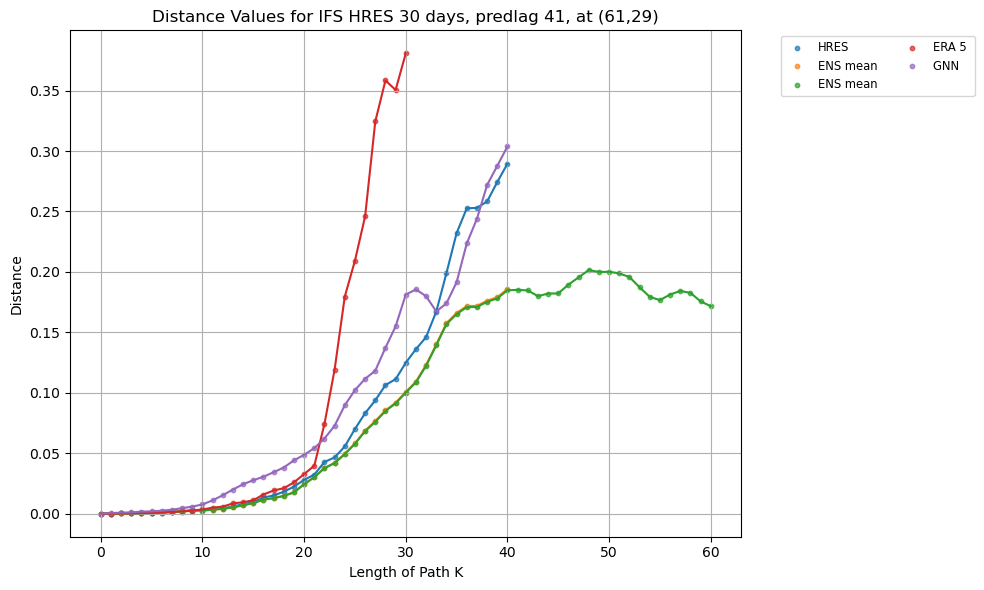

In [265]:
plt.figure(figsize=(10, 6))

# Iterate through each of the 50 models (columns in the array)
plt.scatter(
        np.arange(newdistance1.shape[0]),  # Time steps (x-axis)
        newdistance1[:],     # Model predictions (y-axis)
        label=f'HRES',
        alpha=0.7,                # Adjust transparency
        s=10)
plt.plot(np.arange(newdistance1.shape[0]), newdistance1[:], alpha=1)                # Size of the dots

plt.scatter(
        np.arange(newdistance2.shape[0]),  # Time steps (x-axis)
        newdistance2[:],     # Model predictions (y-axis)
        label=f'ENS mean',
        alpha=0.7,                # Adjust transparency
        s=10) 
plt.plot(np.arange(newdistance2.shape[0]), newdistance2[:], alpha=1)

plt.scatter(
        np.arange(newdistance3.shape[0]),  # Time steps (x-axis)
        newdistance3[:],     # Model predictions (y-axis)
        label=f'ENS mean',
        alpha=0.7,                # Adjust transparency
        s=10)
plt.plot(np.arange(newdistance3.shape[0]), newdistance3[:], alpha=1)

plt.scatter(
        np.arange(newdistance4.shape[0]),  # Time steps (x-axis)
        newdistance4[:],     # Model predictions (y-axis)
        label=f'ERA 5 ',
        alpha=0.7,                # Adjust transparency
        s=10)  
plt.plot(np.arange(newdistance4.shape[0]), newdistance4[:], alpha=1)

plt.scatter(
        np.arange(newdistance5.shape[0]),  # Time steps (x-axis)
        newdistance5[:],     # Model predictions (y-axis)
        label=f'GNN ',
        alpha=0.7,                # Adjust transparency
        s=10)  
plt.plot(np.arange(newdistance5.shape[0]), newdistance5[:], alpha=1)


# Customize the plot
plt.title('Distance Values for IFS HRES 30 days, predlag 41, at (61,29)')
plt.xlabel('Length of Path K')
plt.ylabel('Distance')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)  # Add a legend if desired
plt.tight_layout()

# Show the plot
plt.show()

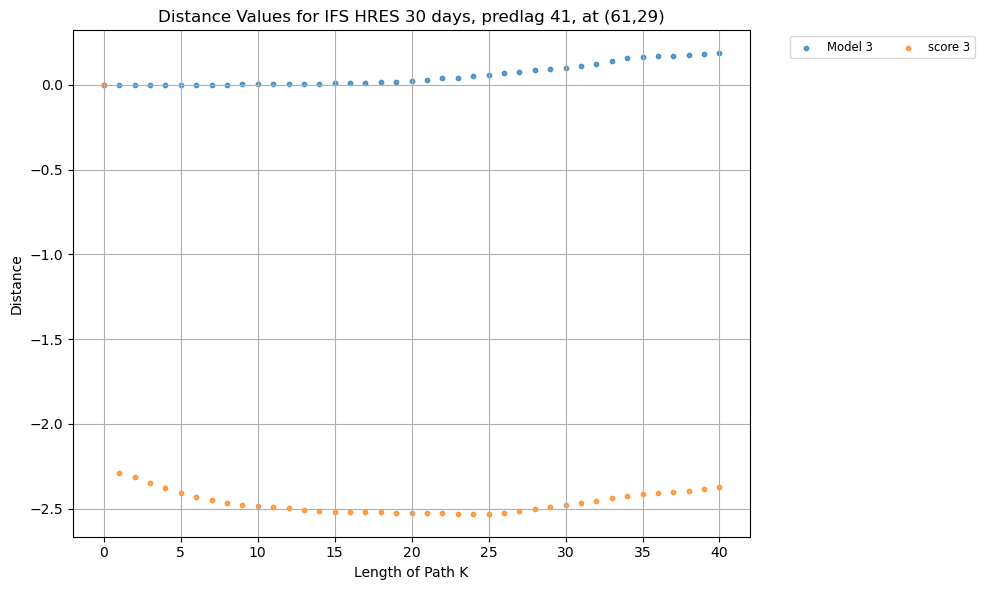

In [251]:
plt.figure(figsize=(10, 6))

# Iterate through each of the 50 models (columns in the array)
plt.scatter(
        np.arange(newdistance2.shape[0]),  # Time steps (x-axis)
        newdistance2[:],     # Model predictions (y-axis)
        label=f'Model {3}',
        alpha=0.7,                # Adjust transparency
        s=10)                # Size of the dots

plt.scatter(
        np.arange(score2.shape[0]),  # Time steps (x-axis)
        score2[:],     # Model predictions (y-axis)
        label=f'score {3}',
        alpha=0.7,                # Adjust transparency
        s=10) 


# Customize the plot
plt.title('Distance Values for IFS HRES 30 days, predlag 41, at (61,29)')
plt.xlabel('Length of Path K')
plt.ylabel('Distance')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)  # Add a legend if desired
plt.tight_layout()

# Show the plot
plt.show()

In [42]:


def pkscaleobs(observations,k,long,lat):
      j = long
      l= lat 

      static_kernel = sigkernel.Linear_ID_Kernel()   #Linear_ID_Kernel()  #RBFKernel(sigma=sigma)
      dyadic_order = 2
      signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
      time = observations.shape[0]/2
      #print(time) #All forecasts on same time frame
      shiftedtime = math.floor(time- 0.5*k)

      vals = 0

      grid = np.zeros((shiftedtime))

      for i in range(shiftedtime): #20
            fors = observations[2*i:2*i+k+1,j,l]
            obs = observations[2*i:2*i+k+1,j,l]

            fors = np.expand_dims(fors, axis = 0)
            obs = np.expand_dims(obs, axis = 0)
            
            llobs = sigkernel.transform(obs, scale = 1, at = True, ll = False)
            llfors = sigkernel.transform(fors, scale = 1, at = True, ll = False)

            X = torch.tensor(llfors, dtype=torch.double)
            y = torch.tensor(llobs, dtype=torch.double)


            K_Xy = signature_kernel.compute_Gram(X, y, sym=False, max_batch=100)
            
            #K_XX - 2* K_Xy
            #signature_kernel.compute_scoring_rule

            grid[i] = K_Xy.item()
      
      vals = sum(grid/shiftedtime)

      return(vals)


def pkscalefors(forecasts,k,long,lat):
        j = long
        l= lat 

        static_kernel = sigkernel.Linear_ID_Kernel()   #Linear_ID_Kernel()  #RBFKernel(sigma=sigma)
        dyadic_order = 2
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
        time = forecasts.shape[0]
        #print(time) #All forecasts on same time frame
        shiftedtime = math.floor(time- 0.5*k)

        vals = np.zeros(forecasts.shape[1])

        
        for f in range(forecasts.shape[1]):
            #print(val)
            grid = np.zeros((shiftedtime))

            for i in range(shiftedtime): #20
                fors = forecasts[i,f,0:k+1,j,l]
                obs = forecasts[i,f,0:k+1,j,l]

                fors = np.expand_dims(fors, axis = 0)
                obs = np.expand_dims(obs, axis = 0)
                
                llobs = sigkernel.transform(obs, scale = 1, at = True, ll = False)
                llfors = sigkernel.transform(fors, scale = 1, at = True, ll = False)

                X = torch.tensor(llfors, dtype=torch.double)
                y = torch.tensor(llobs, dtype=torch.double)


                K_Xy = signature_kernel.compute_Gram(X, y, sym=False, max_batch=100)
                
                #K_XX - 2* K_Xy
                #signature_kernel.compute_scoring_rule

                grid[i] = K_Xy.item()
            
            vals[f] = sum(grid/shiftedtime)

        return(vals)

def pkscaleall50(observations,forecasts,k,long,lat):
        j = long
        l= lat 

        static_kernel = sigkernel.Linear_ID_Kernel()   #Linear_ID_Kernel()  #RBFKernel(sigma=sigma)
        dyadic_order = 2
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
        time = forecasts.shape[0]
        #print(time) #All forecasts on same time frame
        shiftedtime = math.floor(time- 0.5*k)

        vals = np.zeros(forecasts.shape[1])

        for f in range(forecasts.shape[1]):
            #print(val)
            grid = np.zeros((shiftedtime))

            for i in range(shiftedtime): #20
                fors = forecasts[i,f,0:k+1,j,l]
                obs = observations[2*i:2*i+k+1,j,l]

                fors = np.expand_dims(fors, axis = 0)
                obs = np.expand_dims(obs, axis = 0)
                
                llobs = sigkernel.transform(obs, scale = 1, at = True, ll = False)
                llfors = sigkernel.transform(fors, scale = 1, at = True, ll = False)

                X = torch.tensor(llfors, dtype=torch.double)
                y = torch.tensor(llobs, dtype=torch.double)


                K_Xy = signature_kernel.compute_Gram(X, y, sym=False, max_batch=100)
                
                #K_XX - 2* K_Xy
                #signature_kernel.compute_scoring_rule

                grid[i] = K_Xy.item()
            
            vals[f] = sum(grid/shiftedtime)

        return(vals)